In [39]:
# Uncomment the line below with you python version
# if this is the first time you are running the notebook

#!pip install category_encoders
#!pip3 install category_encoders

In [2]:
#imports
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
import category_encoders as ce

from six.moves import urllib
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [3]:
DOWNLOAD_ROOT = "http://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening"
CREDIT_DATA_URL = DOWNLOAD_ROOT + "/crx.data"
CREDIT_DATA_PATH = "datasets/credit-screening"

In [4]:
# fetch data from its origin
def fetch_credit_card_data(credit_data_url=CREDIT_DATA_URL, credit_path=CREDIT_DATA_PATH):
    if not os.path.isdir(credit_path):
        os.makedirs(credit_path)
    credit_data_path = os.path.join(credit_path, "crx.data")
    urllib.request.urlretrieve(credit_data_url, credit_data_path)

fetch_credit_card_data()

In [5]:
# load data from csv file 
def load_credit_card_data(credit_data_path=CREDIT_DATA_PATH):
    csv_path=os.path.join(credit_data_path, "crx.data")
    pd.set_option('display.max_columns', None)
    col_names = ["Gender","Age","Debt","Married","BankCustomer","EducationLevel","Ethnicity","YearsEmployed","PriorDefault","Employed","CreditScore", "DriversLicense", "Citizen", "ZipCode", "Income" , "ApprovalStatus"]
    return pd.read_csv(csv_path, header=None, names=col_names)

dataset = load_credit_card_data()
dataframe = dataset.copy()


In [6]:
dataset = dataset.drop(['DriversLicense', 'ZipCode', 'Ethnicity', 'Gender'], axis=1)

# replace question mark with NaN
# replace + and - with 1 and 0
dataset = dataset.replace("?", np.nan).replace('+', 1).replace('-', 0)

# convert age from object to float
dataset = dataset.astype({"Age": float})
#replace missing numeric values with mean

dataset.fillna(dataset.mean(), inplace=True)
dataset.head(5)

# replace missing object values with the most freequent value
for col in dataset:
    if dataset[col].dtypes == 'object':
        dataset = dataset.fillna(dataset[col].value_counts().index[0])

In [7]:
dataset['ApprovalStatus'].value_counts()

0    383
1    307
Name: ApprovalStatus, dtype: int64

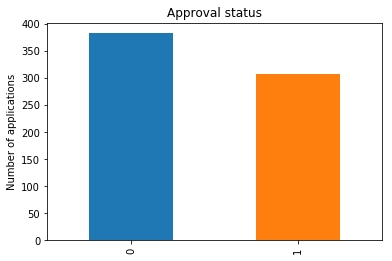

In [8]:
CountStatus = pd.value_counts(dataset['ApprovalStatus'].values, sort=False)
plt.ylabel('Number of applications')
plt.title('Approval status')
CountStatus.plot.bar()

In [9]:
dataset.dtypes

Age               float64
Debt              float64
Married            object
BankCustomer       object
EducationLevel     object
YearsEmployed     float64
PriorDefault       object
Employed           object
CreditScore         int64
Citizen            object
Income              int64
ApprovalStatus      int64
dtype: object

In [10]:
# Label encode for correlation
le = preprocessing.LabelEncoder()

labelEncodedSet = dataset.copy()
for col in dataset:
    if labelEncodedSet[col].dtypes == 'object':
        labelEncodedSet[col]=le.fit_transform(labelEncodedSet[col])

dataset.dtypes

Age               float64
Debt              float64
Married            object
BankCustomer       object
EducationLevel     object
YearsEmployed     float64
PriorDefault       object
Employed           object
CreditScore         int64
Citizen            object
Income              int64
ApprovalStatus      int64
dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CF956230F0>,
      dtype=object)

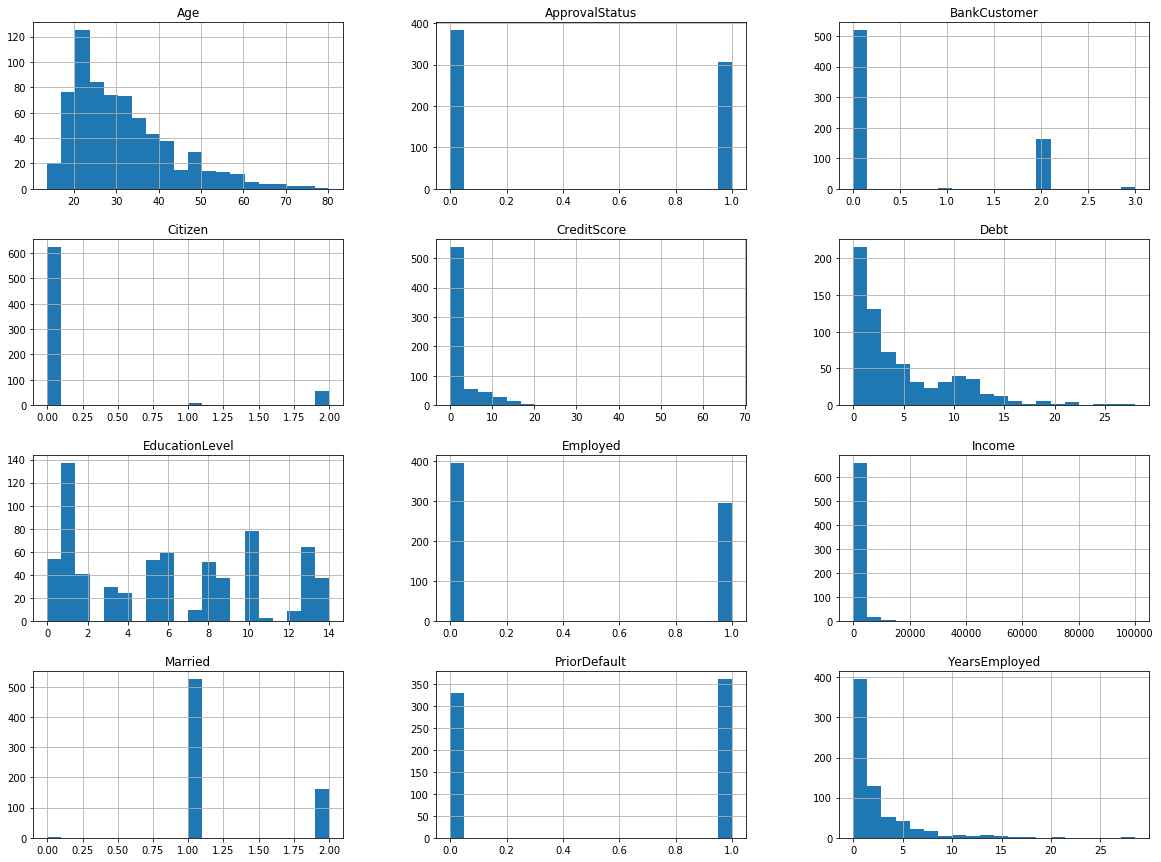

In [38]:
labelEncodedSet.hist(bins=20, figsize=(20, 15))

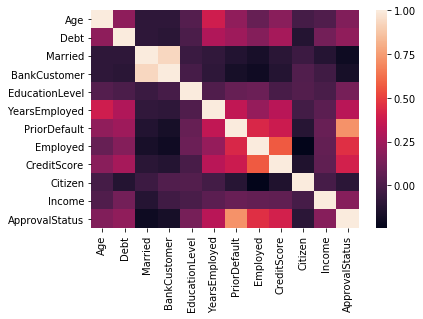

In [12]:
#Correlation heatmap
def make_corr_heatmap(data):
    corr = data.corr()
    sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

make_corr_heatmap(labelEncodedSet)

In [13]:
#Correlation with ApprovalStatus
labelEncodedSet.corr()['ApprovalStatus'].sort_values()

Married          -0.194306
BankCustomer     -0.165491
Citizen          -0.100867
EducationLevel    0.135625
Age               0.161627
Income            0.175657
Debt              0.206294
YearsEmployed     0.322475
CreditScore       0.406410
Employed          0.458301
PriorDefault      0.720407
ApprovalStatus    1.000000
Name: ApprovalStatus, dtype: float64

In [14]:
#use MAD to check the spread of the observation from the mean. MAD > std because we have outliers like age, income
labelEncodedSet.mad()

Age                  9.307123
Debt                 3.941786
Married              0.362222
BankCustomer         0.754354
EducationLevel       3.949422
YearsEmployed        2.223883
PriorDefault         0.498925
Employed             0.489498
CreditScore          3.088116
Citizen              0.320311
Income            1533.165402
ApprovalStatus       0.493934
dtype: float64

In [15]:
#drop columns with the lowest correlation, or columns that do not make sense
#dataset = dataset.drop(['DriversLicense', 'ZipCode', 'Ethnicity', 'Gender'], axis=1)
dataset.head()

,Age,Debt,Married,BankCustomer,EducationLevel,YearsEmployed,PriorDefault,Employed,CreditScore,Citizen,Income,ApprovalStatus
0,30.83,0.000,u,g,w,1.25,t,t,1,g,0,1
1,58.67,4.460,u,g,q,3.04,t,t,6,g,560,1
2,24.50,0.500,u,g,q,1.50,t,f,0,g,824,1
3,27.83,1.540,u,g,w,3.75,t,t,5,g,3,1
4,20.17,5.625,u,g,w,1.71,t,f,0,s,0,1


In [16]:
ohe = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True)
dataset = ohe.fit_transform(dataset)
dataset.head()

,Age,Debt,Married_u,Married_y,Married_l,BankCustomer_g,BankCustomer_p,BankCustomer_u,BankCustomer_gg,EducationLevel_w,EducationLevel_q,EducationLevel_m,EducationLevel_r,EducationLevel_cc,EducationLevel_k,EducationLevel_c,EducationLevel_d,EducationLevel_x,EducationLevel_i,EducationLevel_e,EducationLevel_aa,EducationLevel_ff,EducationLevel_j,EducationLevel_u,YearsEmployed,PriorDefault_t,PriorDefault_f,Employed_t,Employed_f,CreditScore,Citizen_g,Citizen_s,Citizen_p,Income,ApprovalStatus
0,30.83,0.000,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.25,1,0,1,0,1,1,0,0,0,1
1,58.67,4.460,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3.04,1,0,1,0,6,1,0,0,560,1
2,24.50,0.500,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.50,1,0,0,1,0,1,0,0,824,1
3,27.83,1.540,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.75,1,0,1,0,5,1,0,0,3,1
4,20.17,5.625,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.71,1,0,0,1,0,0,1,0,0,1


In [17]:
dataset.corr()['ApprovalStatus'].sort_values()

PriorDefault_f      -0.720407
Employed_f          -0.458301
BankCustomer_p      -0.188964
Married_y           -0.188964
EducationLevel_ff   -0.181588
EducationLevel_i    -0.127762
Citizen_s           -0.109758
EducationLevel_k    -0.096879
EducationLevel_d    -0.090776
EducationLevel_aa   -0.054574
EducationLevel_j    -0.035365
EducationLevel_m    -0.011598
EducationLevel_u    -0.000112
EducationLevel_c     0.007639
EducationLevel_r     0.029485
Citizen_p            0.039245
BankCustomer_u       0.041790
EducationLevel_e     0.044896
EducationLevel_w     0.045487
Married_l            0.060221
BankCustomer_gg      0.060221
Citizen_g            0.089056
EducationLevel_cc    0.132708
EducationLevel_q     0.150082
Age                  0.161627
BankCustomer_g       0.169423
Income               0.175657
Married_u            0.180583
EducationLevel_x     0.192945
Debt                 0.206294
YearsEmployed        0.322475
CreditScore          0.406410
Employed_t           0.458301
PriorDefau

In [18]:
#separate the features and labels
dataset = dataset.values
X,y = dataset[:,0:34] , dataset[:,34]

In [19]:
#split the dataset into train, validation and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [20]:
#rescale the training and testing sets
#scaler = MinMaxScaler(feature_range=(0, 1))
scaler = MinMaxScaler()
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.transform(X_test)
rescaledX_val = scaler.fit_transform(X_val)

In [21]:
#instantiate the algorithms
rfc = RandomForestClassifier(random_state=42, n_estimators=100)
gnb = GaussianNB()
logreg = LogisticRegression(solver='liblinear')

In [43]:
print("Random Forest")

roc_rfc = cross_val_score(rfc, rescaledX_train, y_train, scoring='roc_auc', cv = 5).mean()
f1_rfc = cross_val_score(rfc, rescaledX_train, y_train, scoring='f1', cv = 5).mean()
precision_rfc = cross_val_score(rfc, rescaledX_train, y_train, scoring='precision', cv = 5).mean()
rec_rfc = cross_val_score(rfc, rescaledX_train, y_train, scoring='recall', cv = 5).mean()
acc_rfc = cross_val_score(rfc, rescaledX_train, y_train, scoring='accuracy', cv = 5).mean()

y_pred_rfc = cross_val_predict(rfc, rescaledX_train, y_train, cv=5)
cnf_matrix_rfc = metrics.confusion_matrix(y_train, y_pred_rfc)
tn_rfc, fp_rfc, fn_rfc, tp_rfc = cnf_matrix_rfc.ravel()

yi_rfc = 2*roc_rfc-1
sensitivity_rfc = tp_rfc/(tp_rfc + fn_rfc)
specificity_rfc = tn_rfc/(fp_rfc + tn_rfc)
yi_rfc_formula = sensitivity_rfc - (1 - specificity_rfc)

print("AUC: " , roc_rfc)
print("F1: " , f1_rfc)
print("Precission: " , precision_rfc)
print("Recall (Sensitivity): " , rec_rfc)
print("Accuracy: " , acc_rfc)
print("Sensitivity: " ,  sensitivity_rfc)
print("Specificity: " ,  specificity_rfc)
print("Youden's index", yi_rfc)
print("Youden's index formula", yi_rfc_formula)
print("True Negatives: ",tn_rfc)
print("False Positives: ",fp_rfc)
print("False Negatives: ",fn_rfc)
print("True Positives: ",tp_rfc)

Random Forest
AUC:  0.9160792123392743
F1:  0.839058160647976
Precission:  0.8275687632465851
Recall (Sensitivity):  0.8570412517780939
Accuracy:  0.8574786023739918
Sensitivity:  0.8571428571428571
Specificity:  0.8571428571428571
Youden's index 0.8321584246785485
Youden's index formula 0.7142857142857142
True Negatives:  216
False Positives:  36
False Negatives:  27
True Positives:  162


In [23]:
print("Naive Bayes")

roc_gnb = cross_val_score(gnb, rescaledX_train, y_train, scoring='roc_auc', cv = 5).mean()
f1_gnb = cross_val_score(gnb, rescaledX_train, y_train, scoring='f1', cv = 5).mean()
precision_gnb = cross_val_score(gnb, rescaledX_train, y_train, scoring='precision', cv = 5).mean()
rec_gnb = cross_val_score(gnb, rescaledX_train, y_train, scoring='recall', cv = 5).mean()
acc_gnb= cross_val_score(gnb, rescaledX_train, y_train, scoring='accuracy', cv = 5).mean()

y_pred_gnb = cross_val_predict(gnb, rescaledX_train, y_train, cv=5)
cnf_matrix_gnb = metrics.confusion_matrix(y_train,y_pred_gnb)
tn_gnb, fp_gnb, fn_gnb, tp_gnb = cnf_matrix_gnb.ravel()

yi_gnb = 2*roc_gnb-1
sensitivity_gnb = tp_gnb/(tp_gnb+fn_gnb)
specificity_gnb = tn_gnb/(fp_gnb+tn_gnb)
yi_gnb_formula = sensitivity_gnb - (1 - specificity_gnb)

print("AUC" , roc_gnb)
print("F1: " , f1_gnb)
print("Precission: " , precision_gnb)
print("Recall (Sensitivity):" , rec_gnb)
print("Accuracy: " , acc_gnb)
print("Sensitivity: " ,  sensitivity_gnb)
print("Specificity: " ,  specificity_gnb)
print("Youden's index: ", yi_gnb)
print("Youden's index formula: ", yi_gnb_formula)
print("True Negatives: ",tn_gnb)
print("False Positives: ",fp_gnb)
print("False Negatives: ",fn_gnb)
print("True Positives: ",tp_gnb)

Naive Bayes
AUC 0.8645021894959977
F1:  0.5047819461360978
Precission:  0.8648711390910881
Recall (Sensitivity): 0.36443812233285916
Accuracy:  0.7029451821586653
Sensitivity:  0.36507936507936506
Specificity:  0.9563492063492064
Youden's index:  0.7290043789919953
Youden's index formula:  0.32142857142857145
True Negatives:  241
False Positives:  11
False Negatives:  120
True Positives:  69


In [24]:
print("Logistic regression")

roc_logreg = cross_val_score(logreg, rescaledX_train, y_train, scoring='roc_auc', cv = 5).mean()
f1_logreg = cross_val_score(logreg, rescaledX_train, y_train, scoring='f1', cv = 5).mean()
precision_logreg = cross_val_score(logreg, rescaledX_train, y_train, scoring='precision', cv = 5).mean()
rec_logreg = cross_val_score(logreg, rescaledX_train, y_train, scoring='recall', cv = 5).mean()
acc_logreg = cross_val_score(logreg, rescaledX_train, y_train, scoring='accuracy', cv = 5).mean()

y_pred_val_logreg = cross_val_predict(logreg, rescaledX_train, y_train, cv=5)
# Compute confusion matrix
cnf_matrix_logreg = metrics.confusion_matrix(y_train, y_pred_val_logreg)
tn_logreg, fp_logreg, fn_logreg, tp_logreg = cnf_matrix_logreg.ravel()

yi_logreg = 2*roc_logreg-1
sensitivity_logreg = tp_logreg/(tp_logreg+fn_logreg)
specificity_logreg = tn_logreg/(fp_logreg+tn_logreg)
yi_logreg_formula = sensitivity_logreg - (1 - specificity_logreg)

print("AUC of Logistic Regression is: " , roc_logreg)
print("F1: " , f1_logreg)
print("Precision: " , precision_logreg)
print("Recall (Sensitivity): " , rec_logreg)
print("Accuracy: " , acc_logreg)
print("Sensitivity: " ,  sensitivity_logreg)
print("Specificity: " ,  specificity_logreg)
print("Youden's index", yi_logreg)
print("Youden's index formula", yi_logreg_formula)
print("True Negatives: ",tn_logreg)
print("False Positives: ",fp_logreg)
print("False Negatives: ",fn_logreg)
print("True Positives: ",tp_logreg)


Logistic regression
AUC of Logistic Regression is:  0.9073592725852787
F1:  0.8319986513123767
Precision:  0.7995251161505491
Recall (Sensitivity):  0.8726884779516357
Accuracy:  0.8483087363366325
Sensitivity:  0.873015873015873
Specificity:  0.8293650793650794
Youden's index 0.8147185451705574
Youden's index formula 0.7023809523809524
True Negatives:  209
False Positives:  43
False Negatives:  24
True Positives:  165


In [25]:
import itertools    

# function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Random forest
Confusion matrix, without normalization
[[216  36]
 [ 27 162]]


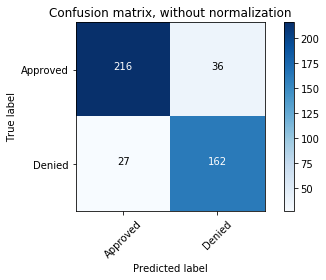

In [26]:
print("Random forest")
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_rfc, classes=['Approved','Denied'],
                      title='Confusion matrix, without normalization')

Naive Bayes
Confusion matrix, without normalization
[[241  11]
 [120  69]]


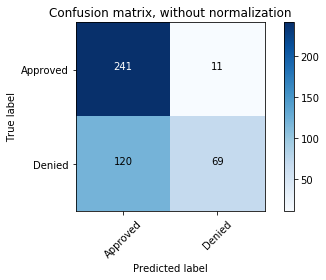

In [27]:
print("Naive Bayes")
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_gnb, classes=['Approved','Denied'],
                      title='Confusion matrix, without normalization')

Logistic regression
Confusion matrix, without normalization
[[209  43]
 [ 24 165]]


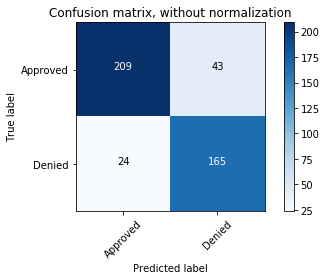

In [28]:
print("Logistic regression")
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_logreg, classes=['Approved','Denied'],
                      title='Confusion matrix, without normalization')

In [42]:
param_grid = {
    'max_depth': np.linspace(1, 32, 32, endpoint=True),
    'max_features': list(range(1,rescaledX_train.shape[1])),
    'min_samples_leaf': np.linspace(0.1, 0.5, 5, endpoint=True),
    'min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True),
    'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200]
}
#grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          #cv = 5, n_jobs = -1, verbose = 2)
#grid_search.fit(rescaledX_val, y_val)

#rgs = RandomizedSearchCV(estimator=rfc, param_distributions  = param_grid, n_iter = 5000, cv = 10, n_jobs = -1, verbose = 2)
#rgs.fit(rescaledX_val, y_val)

#rgs.best_params_

In [30]:
#instantiate rfc with the best parameters
#rfc_best_model = RandomForestClassifier(max_depth=26.0,max_features=3,min_samples_leaf=0.1,min_samples_split= 0.3,n_estimators=8,random_state=42)
rfc_best_model = RandomForestClassifier(max_depth=20.0,max_features=3,min_samples_leaf=0.1,min_samples_split= 0.3,n_estimators=10,random_state=42)
#fit the train data
rfc_best_model.fit(rescaledX_train, y_train)
#predict on validation set
y_pred_val = rfc_best_model.predict(rescaledX_val)

In [31]:
#print the metrics for validation set
roc = metrics.roc_auc_score(y_val,y_pred_val)
f1 = metrics.f1_score(y_val,y_pred_val)
precision = metrics.precision_score(y_val,y_pred_val)
recall = metrics.recall_score(y_val,y_pred_val)
acc = metrics.accuracy_score(y_val,y_pred_val)

cnf_matrix = metrics.confusion_matrix(y_val,y_pred_val)
tn, fp, fn, tp = cnf_matrix.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (fp + tn)

yi = 2*roc-1
yi_formula = sensitivity - (1 - specificity)

print("AUC: " , roc)
print("F1: " , f1)
print("Precission: " , precision)
print("Recall (Sensitivity): " , recall)
print("Accuracy: " , acc )
print("Sensitivity: " ,  sensitivity)
print("Specificity: " ,  specificity)
print("Youden's index", yi)
print("Youden's formula", yi_formula)
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)      

AUC:  0.8923701298701299
F1:  0.8965517241379309
Precission:  0.8524590163934426
Recall (Sensitivity):  0.9454545454545454
Accuracy:  0.8918918918918919
Sensitivity:  0.9454545454545454
Specificity:  0.8392857142857143
Youden's index 0.7847402597402597
Youden's formula 0.7847402597402597
True Negatives:  47
False Positives:  9
False Negatives:  3
True Positives:  52


Confusion matrix, without normalization
[[47  9]
 [ 3 52]]


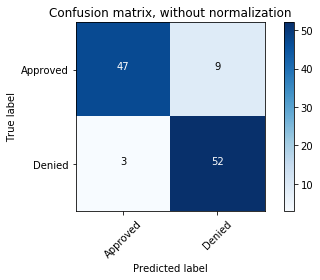

In [32]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Approved','Denied'],
                      title='Confusion matrix, without normalization')

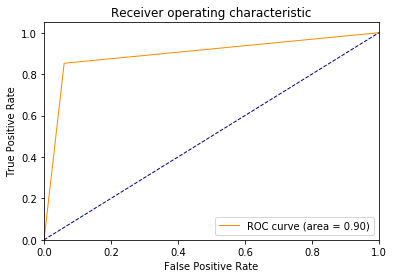

In [33]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_pred_val, y_val)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [34]:
#instantiate rfc with the best parameters
rfc_best_model = RandomForestClassifier(max_depth=20.0,max_features=3,min_samples_leaf=0.1,min_samples_split= 0.3,n_estimators=10,random_state=42)

#fit the train data
rfc_best_model.fit(rescaledX_test, y_test)
#predict on test set
y_pred_val = rfc_best_model.predict(rescaledX_test)

In [35]:
#print the metrics for test set
roc = metrics.roc_auc_score(y_test,y_pred_val)
f1 = metrics.f1_score(y_test,y_pred_val)
precision = metrics.precision_score(y_test,y_pred_val)
recall = metrics.recall_score(y_test,y_pred_val)
acc = metrics.accuracy_score(y_test,y_pred_val)

cnf_matrix = metrics.confusion_matrix(y_test,y_pred_val)
tn, fp, fn, tp = cnf_matrix.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (fp + tn)

yi = 2*roc-1
yi_formula = sensitivity - (1 - specificity)

print("AUC: " , roc)
print("F1: " , f1)
print("Precission: " , precision)
print("Recall (Sensitivity): " , recall)
print("Accuracy: " , acc )
print("Sensitivity: " ,  sensitivity)
print("Specificity: " ,  specificity)
print("Youden's index", yi)
print("Youden's formula", yi_formula)
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)      
      

AUC:  0.9057142857142857
F1:  0.8976377952755906
Precission:  0.890625
Recall (Sensitivity):  0.9047619047619048
Accuracy:  0.9057971014492754
Sensitivity:  0.9047619047619048
Specificity:  0.9066666666666666
Youden's index 0.8114285714285714
Youden's formula 0.8114285714285714
True Negatives:  68
False Positives:  7
False Negatives:  6
True Positives:  57


Confusion matrix, without normalization
[[68  7]
 [ 6 57]]


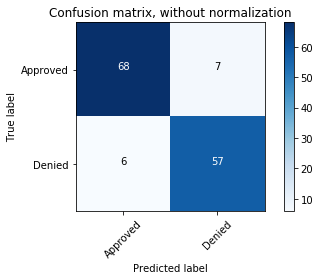

In [36]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Approved','Denied'],
                      title='Confusion matrix, without normalization')